## Setup the Env


In [79]:
import os
import sys

import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()
role

# Add the parent directory to the sys.path
sys.path.insert(0, os.path.abspath(".."))

# Take a look at current dir
print(os.getcwd())

from utils.file_utilities import s3_download, s3_upload

/home/sagemaker-user/capstone-2024-summer/src/shuo


## Import Package


In [80]:
!pip install seaborn
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import warnings
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import joblib
import time
import logging
import torch.distributions as dist
from sklearn.preprocessing import StandardScaler


warnings.filterwarnings("ignore")
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

In [81]:
# pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113

In [82]:
torch.cuda.is_available()

True

In [83]:
import torch
import torch.nn as nn

# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

# Example model
model = nn.Linear(10, 2)

# Move model to the device (GPU if available)
model.to(device)

# Example data
x = torch.randn(1, 10).to(device)
output = model(x)
print(output)

CUDA is available. Using GPU.
tensor([[ 0.5081, -0.4619]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [84]:
pd.set_option("display.max_rows", 20)
pd.set_option("display.max_columns", 500)

## Load Data


In [85]:
# reload_path = s3_download("CRSP/crsp_2018-2023_clean_3.parquet")
# reload_path

In [86]:
df = pd.read_parquet("../../data/crsp_2018-2023_clean_3_compustat.parquet")

In [87]:
df

,date,permno_id,log_return,abs_log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,log_return_7,abs_log_return_7,log_return_14,abs_log_return_14,log_return_28,abs_log_return_28,volatility_7,volatility_14,volatility_28,oth_assets,assets,oth_liabs,liabs,retained_earning,equity,net_sales,cogs,operating_exp,income_b4_extraordinary,pretax_income,income_tax,net_income,common_shares_issued,common_shares_outstanding,preferred_stock,earnings_per_share_diluted_w_extraordinary,earnings_per_share_diluted_wo_extraordinary,earnings_per_share_basic_w_extraordinary,earnings_per_share_basic_wo_extraordinary
0,2018-04-02,10104,-0.704072,0.059017,-1.214889,-1.282663,-1.727419,-1.574351,0.017497,-0.348569,0.264136,-0.440244,0.300953,-0.428934,-0.281168,-0.579628,-0.763897,54565.0,138201.0,15737.0,89929.0,18741.0,48272.0,9676.0,1693.0,5571.0,-4047.0,3227.0,7238.0,-4047.0,4093.0,4093.0,0.0,-0.98,-0.98,-0.98,-0.98
1,2018-04-03,10104,-0.127541,-0.694653,0.735753,0.864778,0.942342,0.882990,0.117286,-0.237420,0.182365,-0.552431,0.303736,-0.425062,-0.287127,-0.553916,-0.764282,54565.0,138201.0,15737.0,89929.0,18741.0,48272.0,9676.0,1693.0,5571.0,-4047.0,3227.0,7238.0,-4047.0,4093.0,4093.0,0.0,-0.98,-0.98,-0.98,-0.98
2,2018-04-04,10104,0.565218,-0.084103,0.767533,0.700278,0.790000,0.817181,0.008453,-0.358642,-0.054081,-0.876829,0.185711,-0.589231,-0.336797,-0.581217,-0.786099,54565.0,138201.0,15737.0,89929.0,18741.0,48272.0,9676.0,1693.0,5571.0,-4047.0,3227.0,7238.0,-4047.0,4093.0,4093.0,0.0,-0.98,-0.98,-0.98,-0.98
3,2018-04-05,10104,0.401274,-0.298419,0.409771,0.433501,0.539389,0.499544,-0.062650,-0.437839,-0.113585,-0.943439,0.099541,-0.709091,-0.365253,-0.599106,-0.797575,54565.0,138201.0,15737.0,89929.0,18741.0,48272.0,9676.0,1693.0,5571.0,-4047.0,3227.0,7238.0,-4047.0,4093.0,4093.0,0.0,-0.98,-0.98,-0.98,-0.98
4,2018-04-06,10104,-1.067089,0.533570,-0.979809,-0.963374,-1.611880,-1.871488,0.398623,0.075944,0.241401,-0.471437,0.298674,-0.432103,-0.748618,-0.784244,-0.906251,54565.0,138201.0,15737.0,89929.0,18741.0,48272.0,9676.0,1693.0,5571.0,-4047.0,3227.0,7238.0,-4047.0,4093.0,4093.0,0.0,-0.98,-0.98,-0.98,-0.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735770,2023-12-22,93436,-0.341505,-0.414949,-0.004407,0.442444,0.163436,0.338492,-0.128265,-0.510924,-0.108108,-0.950953,-0.091799,-0.975239,-1.313432,-1.456839,-1.568281,6122.0,93941.0,7199.0,39446.0,19262.0,54218.0,23350.0,17937.0,20351.0,1853.0,2045.0,167.0,1853.0,3179.0,3179.0,0.0,0.53,0.53,0.58,0.58
735771,2023-12-26,93436,0.661183,0.041348,0.378694,0.605155,0.366081,0.290950,-0.128265,-0.510924,-0.108108,-0.950953,-0.091799,-0.975239,-1.313432,-1.456839,-1.568281,6122.0,93941.0,7199.0,39446.0,19262.0,54218.0,23350.0,17937.0,20351.0,1853.0,2045.0,167.0,1853.0,3179.0,3179.0,0.0,0.53,0.53,0.58,0.58
735772,2023-12-27,93436,0.773615,0.188324,0.108477,0.079842,0.099407,0.074778,-0.128265,-0.510924,-0.108108,-0.950953,-0.091799,-0.975239,-1.313432,-1.456839,-1.568281,6122.0,93941.0,7199.0,39446.0,19262.0,54218.0,23350.0,17937.0,20351.0,1853.0,2045.0,167.0,1853.0,3179.0,3179.0,0.0,0.53,0.53,0.58,0.58
735773,2023-12-28,93436,-1.371871,0.931997,-0.096988,-0.022818,-0.045319,0.156221,-0.128265,-0.510924,-0.108108,-0.950953,-0.091799,-0.975239,-1.313432,-1.456839,-1.568281,6122.0,93941.0,7199.0,39446.0,19262.0,54218.0,23350.0,17937.0,20351.0,1853.0,2045.0,167.0,1853.0,3179.0,3179.0,0.0,0.53,0.53,0.58,0.58


In [88]:
df = df.drop_duplicates(subset = ["date", "permno_id"], keep = "last")

In [89]:
# Read the permno_ids from the text file
with open("./test_permno.txt", "r") as file:
    test_permno_ids = file.read().splitlines()

# Convert the permno_ids to integers (if necessary)
test_permno_ids = [permno_id for permno_id in test_permno_ids]

print(f"No. of Permno_ids: {len(test_permno_ids)}")
# # Filter the dataframe to include only the rows with permno_ids in the test_permno_ids list
df = df[df["permno_id"].isin(test_permno_ids)]

df

No. of Permno_ids: 472


,date,permno_id,log_return,abs_log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,log_return_7,abs_log_return_7,log_return_14,abs_log_return_14,log_return_28,abs_log_return_28,volatility_7,volatility_14,volatility_28,oth_assets,assets,oth_liabs,liabs,retained_earning,equity,net_sales,cogs,operating_exp,income_b4_extraordinary,pretax_income,income_tax,net_income,common_shares_issued,common_shares_outstanding,preferred_stock,earnings_per_share_diluted_w_extraordinary,earnings_per_share_diluted_wo_extraordinary,earnings_per_share_basic_w_extraordinary,earnings_per_share_basic_wo_extraordinary
0,2018-04-02,10104,-0.704072,0.059017,-1.214889,-1.282663,-1.727419,-1.574351,0.017497,-0.348569,0.264136,-0.440244,0.300953,-0.428934,-0.281168,-0.579628,-0.763897,54565.0,138201.0,15737.0,89929.0,18741.0,48272.0,9676.0,1693.0,5571.0,-4047.0,3227.0,7238.0,-4047.0,4093.0,4093.0,0.0,-0.98,-0.98,-0.98,-0.98
1,2018-04-03,10104,-0.127541,-0.694653,0.735753,0.864778,0.942342,0.882990,0.117286,-0.237420,0.182365,-0.552431,0.303736,-0.425062,-0.287127,-0.553916,-0.764282,54565.0,138201.0,15737.0,89929.0,18741.0,48272.0,9676.0,1693.0,5571.0,-4047.0,3227.0,7238.0,-4047.0,4093.0,4093.0,0.0,-0.98,-0.98,-0.98,-0.98
2,2018-04-04,10104,0.565218,-0.084103,0.767533,0.700278,0.790000,0.817181,0.008453,-0.358642,-0.054081,-0.876829,0.185711,-0.589231,-0.336797,-0.581217,-0.786099,54565.0,138201.0,15737.0,89929.0,18741.0,48272.0,9676.0,1693.0,5571.0,-4047.0,3227.0,7238.0,-4047.0,4093.0,4093.0,0.0,-0.98,-0.98,-0.98,-0.98
3,2018-04-05,10104,0.401274,-0.298419,0.409771,0.433501,0.539389,0.499544,-0.062650,-0.437839,-0.113585,-0.943439,0.099541,-0.709091,-0.365253,-0.599106,-0.797575,54565.0,138201.0,15737.0,89929.0,18741.0,48272.0,9676.0,1693.0,5571.0,-4047.0,3227.0,7238.0,-4047.0,4093.0,4093.0,0.0,-0.98,-0.98,-0.98,-0.98
4,2018-04-06,10104,-1.067089,0.533570,-0.979809,-0.963374,-1.611880,-1.871488,0.398623,0.075944,0.241401,-0.471437,0.298674,-0.432103,-0.748618,-0.784244,-0.906251,54565.0,138201.0,15737.0,89929.0,18741.0,48272.0,9676.0,1693.0,5571.0,-4047.0,3227.0,7238.0,-4047.0,4093.0,4093.0,0.0,-0.98,-0.98,-0.98,-0.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735770,2023-12-22,93436,-0.341505,-0.414949,-0.004407,0.442444,0.163436,0.338492,-0.128265,-0.510924,-0.108108,-0.950953,-0.091799,-0.975239,-1.313432,-1.456839,-1.568281,6122.0,93941.0,7199.0,39446.0,19262.0,54218.0,23350.0,17937.0,20351.0,1853.0,2045.0,167.0,1853.0,3179.0,3179.0,0.0,0.53,0.53,0.58,0.58
735771,2023-12-26,93436,0.661183,0.041348,0.378694,0.605155,0.366081,0.290950,-0.128265,-0.510924,-0.108108,-0.950953,-0.091799,-0.975239,-1.313432,-1.456839,-1.568281,6122.0,93941.0,7199.0,39446.0,19262.0,54218.0,23350.0,17937.0,20351.0,1853.0,2045.0,167.0,1853.0,3179.0,3179.0,0.0,0.53,0.53,0.58,0.58
735772,2023-12-27,93436,0.773615,0.188324,0.108477,0.079842,0.099407,0.074778,-0.128265,-0.510924,-0.108108,-0.950953,-0.091799,-0.975239,-1.313432,-1.456839,-1.568281,6122.0,93941.0,7199.0,39446.0,19262.0,54218.0,23350.0,17937.0,20351.0,1853.0,2045.0,167.0,1853.0,3179.0,3179.0,0.0,0.53,0.53,0.58,0.58
735773,2023-12-28,93436,-1.371871,0.931997,-0.096988,-0.022818,-0.045319,0.156221,-0.128265,-0.510924,-0.108108,-0.950953,-0.091799,-0.975239,-1.313432,-1.456839,-1.568281,6122.0,93941.0,7199.0,39446.0,19262.0,54218.0,23350.0,17937.0,20351.0,1853.0,2045.0,167.0,1853.0,3179.0,3179.0,0.0,0.53,0.53,0.58,0.58


In [90]:
df.dtypes

date                                           datetime64[ns]
permno_id                                              object
log_return                                            float64
abs_log_return                                        float64
sector_weighted_avg_log_return                        float64
                                                    ...      
preferred_stock                                       float64
earnings_per_share_diluted_w_extraordinary            float64
earnings_per_share_diluted_wo_extraordinary           float64
earnings_per_share_basic_w_extraordinary              float64
earnings_per_share_basic_wo_extraordinary             float64
Length: 37, dtype: object

## Feature Engineering


### Feature Selection


In [91]:
data = df[
    [
        "date",
        "permno_id",
        # "naics",
        "log_return",
        "abs_log_return",
        "sector_weighted_avg_log_return",
        "sector_simple_avg_log_return",
        "weighted_avg_log_return",
        "simple_avg_log_return",
        "log_return_7",
        "abs_log_return_7",
        "log_return_14",
        "abs_log_return_14",
        "log_return_28",
        "abs_log_return_28",
        "volatility_7",
        "volatility_14",
        "volatility_28",
        'assets', 
        'liabs', 
        'retained_earning', 
        'net_sales', 
        'net_income', 
        'common_shares_outstanding'
    ]
]
data

,date,permno_id,log_return,abs_log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,log_return_7,abs_log_return_7,log_return_14,abs_log_return_14,log_return_28,abs_log_return_28,volatility_7,volatility_14,volatility_28,assets,liabs,retained_earning,net_sales,net_income,common_shares_outstanding
0,2018-04-02,10104,-0.704072,0.059017,-1.214889,-1.282663,-1.727419,-1.574351,0.017497,-0.348569,0.264136,-0.440244,0.300953,-0.428934,-0.281168,-0.579628,-0.763897,138201.0,89929.0,18741.0,9676.0,-4047.0,4093.0
1,2018-04-03,10104,-0.127541,-0.694653,0.735753,0.864778,0.942342,0.882990,0.117286,-0.237420,0.182365,-0.552431,0.303736,-0.425062,-0.287127,-0.553916,-0.764282,138201.0,89929.0,18741.0,9676.0,-4047.0,4093.0
2,2018-04-04,10104,0.565218,-0.084103,0.767533,0.700278,0.790000,0.817181,0.008453,-0.358642,-0.054081,-0.876829,0.185711,-0.589231,-0.336797,-0.581217,-0.786099,138201.0,89929.0,18741.0,9676.0,-4047.0,4093.0
3,2018-04-05,10104,0.401274,-0.298419,0.409771,0.433501,0.539389,0.499544,-0.062650,-0.437839,-0.113585,-0.943439,0.099541,-0.709091,-0.365253,-0.599106,-0.797575,138201.0,89929.0,18741.0,9676.0,-4047.0,4093.0
4,2018-04-06,10104,-1.067089,0.533570,-0.979809,-0.963374,-1.611880,-1.871488,0.398623,0.075944,0.241401,-0.471437,0.298674,-0.432103,-0.748618,-0.784244,-0.906251,138201.0,89929.0,18741.0,9676.0,-4047.0,4093.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735770,2023-12-22,93436,-0.341505,-0.414949,-0.004407,0.442444,0.163436,0.338492,-0.128265,-0.510924,-0.108108,-0.950953,-0.091799,-0.975239,-1.313432,-1.456839,-1.568281,93941.0,39446.0,19262.0,23350.0,1853.0,3179.0
735771,2023-12-26,93436,0.661183,0.041348,0.378694,0.605155,0.366081,0.290950,-0.128265,-0.510924,-0.108108,-0.950953,-0.091799,-0.975239,-1.313432,-1.456839,-1.568281,93941.0,39446.0,19262.0,23350.0,1853.0,3179.0
735772,2023-12-27,93436,0.773615,0.188324,0.108477,0.079842,0.099407,0.074778,-0.128265,-0.510924,-0.108108,-0.950953,-0.091799,-0.975239,-1.313432,-1.456839,-1.568281,93941.0,39446.0,19262.0,23350.0,1853.0,3179.0
735773,2023-12-28,93436,-1.371871,0.931997,-0.096988,-0.022818,-0.045319,0.156221,-0.128265,-0.510924,-0.108108,-0.950953,-0.091799,-0.975239,-1.313432,-1.456839,-1.568281,93941.0,39446.0,19262.0,23350.0,1853.0,3179.0


### Standardize features and labels


In [92]:
columns = [
    "log_return",
    "sector_weighted_avg_log_return",
    "sector_simple_avg_log_return",
    "weighted_avg_log_return",
    "simple_avg_log_return",
    "abs_log_return",
    "log_return_7",
    "abs_log_return_7",
    "log_return_14",
    "abs_log_return_14",
    "log_return_28",
    "abs_log_return_28",
    "volatility_7",
    "volatility_14",
    "volatility_28",
    'assets', 
    'liabs', 
    'retained_earning', 
    'net_sales', 
    'net_income', 
    'common_shares_outstanding'
]
scaler = StandardScaler()

data[columns] = scaler.fit_transform(data[columns])
data

,date,permno_id,log_return,abs_log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,log_return_7,abs_log_return_7,log_return_14,abs_log_return_14,log_return_28,abs_log_return_28,volatility_7,volatility_14,volatility_28,assets,liabs,retained_earning,net_sales,net_income,common_shares_outstanding
0,2018-04-02,10104,-0.722640,0.076110,-1.219960,-1.282184,-1.723323,-1.586863,0.021190,-0.355287,0.266100,-0.440822,0.298451,-0.432174,-0.265091,-0.569368,-0.757051,0.224483,0.114673,0.181999,0.223107,-2.420841,2.851233
1,2018-04-03,10104,-0.132135,-0.699120,0.737339,0.862030,0.937017,0.887506,0.125985,-0.237855,0.181901,-0.557423,0.301313,-0.428149,-0.271239,-0.542828,-0.757448,0.224483,0.114673,0.181999,0.223107,-2.420841,2.851233
2,2018-04-04,10104,0.577416,-0.071104,0.769228,0.697777,0.785212,0.821241,0.011693,-0.365929,-0.061570,-0.894584,0.179978,-0.598804,-0.322480,-0.571007,-0.779956,0.224483,0.114673,0.181999,0.223107,-2.420841,2.851233
3,2018-04-05,10104,0.409498,-0.291551,0.410244,0.431401,0.535486,0.501403,-0.062977,-0.449603,-0.122841,-0.963815,0.091392,-0.723398,-0.351837,-0.589473,-0.791795,0.224483,0.114673,0.181999,0.223107,-2.420841,2.851233
4,2018-04-06,10104,-1.094456,0.564239,-0.984078,-0.963375,-1.608192,-1.886059,0.421436,0.093221,0.242690,-0.473241,0.296109,-0.435469,-0.747334,-0.780574,-0.903910,0.224483,0.114673,0.181999,0.223107,-2.420841,2.851233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735770,2023-12-22,93436,-0.351285,-0.411415,-0.005347,0.440331,0.160859,0.339234,-0.131885,-0.526819,-0.117202,-0.971625,-0.105313,-1.000059,-1.330021,-1.474834,-1.586892,0.056889,-0.096473,0.198109,1.244559,0.583198,2.099713
735771,2023-12-26,93436,0.675707,0.057935,0.379062,0.602798,0.362789,0.291363,-0.131885,-0.526819,-0.117202,-0.971625,-0.105313,-1.000059,-1.330021,-1.474834,-1.586892,0.056889,-0.096473,0.198109,1.244559,0.583198,2.099713
735772,2023-12-27,93436,0.790864,0.209116,0.107922,0.078274,0.097056,0.073693,-0.131885,-0.526819,-0.117202,-0.971625,-0.105313,-1.000059,-1.330021,-1.474834,-1.586892,0.056889,-0.096473,0.198109,1.244559,0.583198,2.099713
735773,2023-12-28,93436,-1.406626,0.974064,-0.098244,-0.024233,-0.047158,0.155701,-0.131885,-0.526819,-0.117202,-0.971625,-0.105313,-1.000059,-1.330021,-1.474834,-1.586892,0.056889,-0.096473,0.198109,1.244559,0.583198,2.099713


### Select number of stocks


In [93]:
data["permno_id"].nunique()

472

In [94]:
# Function to filter the first n stocks
def filter_first_n_stocks(data, n):
    first_n_permno_ids = data["permno_id"].unique()[:n]
    return data[data["permno_id"].isin(first_n_permno_ids)]

In [95]:
# Filter the first n stocks
n_stocks = 96  # Adjust n as needed
data = filter_first_n_stocks(data, n_stocks)
data

,date,permno_id,log_return,abs_log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,log_return_7,abs_log_return_7,log_return_14,abs_log_return_14,log_return_28,abs_log_return_28,volatility_7,volatility_14,volatility_28,assets,liabs,retained_earning,net_sales,net_income,common_shares_outstanding
0,2018-04-02,10104,-0.722640,0.076110,-1.219960,-1.282184,-1.723323,-1.586863,0.021190,-0.355287,0.266100,-0.440822,0.298451,-0.432174,-0.265091,-0.569368,-0.757051,0.224483,0.114673,0.181999,0.223107,-2.420841,2.851233
1,2018-04-03,10104,-0.132135,-0.699120,0.737339,0.862030,0.937017,0.887506,0.125985,-0.237855,0.181901,-0.557423,0.301313,-0.428149,-0.271239,-0.542828,-0.757448,0.224483,0.114673,0.181999,0.223107,-2.420841,2.851233
2,2018-04-04,10104,0.577416,-0.071104,0.769228,0.697777,0.785212,0.821241,0.011693,-0.365929,-0.061570,-0.894584,0.179978,-0.598804,-0.322480,-0.571007,-0.779956,0.224483,0.114673,0.181999,0.223107,-2.420841,2.851233
3,2018-04-05,10104,0.409498,-0.291551,0.410244,0.431401,0.535486,0.501403,-0.062977,-0.449603,-0.122841,-0.963815,0.091392,-0.723398,-0.351837,-0.589473,-0.791795,0.224483,0.114673,0.181999,0.223107,-2.420841,2.851233
4,2018-04-06,10104,-1.094456,0.564239,-0.984078,-0.963375,-1.608192,-1.886059,0.421436,0.093221,0.242690,-0.473241,0.296109,-0.435469,-0.747334,-0.780574,-0.903910,0.224483,0.114673,0.181999,0.223107,-2.420841,2.851233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152081,2023-12-22,18163,0.288549,-0.450336,0.415623,1.031704,0.160859,0.339234,-0.131885,-0.526819,-0.117202,-0.971625,-0.105313,-1.000059,-1.330021,-1.474834,-1.586892,0.165147,0.050212,2.937809,1.134077,1.941635,1.423744
152082,2023-12-26,18163,0.179720,-0.593210,0.219724,0.532313,0.362789,0.291363,-0.131885,-0.526819,-0.117202,-0.971625,-0.105313,-1.000059,-1.330021,-1.474834,-1.586892,0.165147,0.050212,2.937809,1.134077,1.941635,1.423744
152083,2023-12-27,18163,0.019033,-0.804163,0.199515,0.256687,0.097056,0.073693,-0.131885,-0.526819,-0.117202,-0.971625,-0.105313,-1.000059,-1.330021,-1.474834,-1.586892,0.165147,0.050212,2.937809,1.134077,1.941635,1.423744
152084,2023-12-28,18163,-0.114469,-0.722313,-0.148278,-0.092549,-0.047158,0.155701,-0.131885,-0.526819,-0.117202,-0.971625,-0.105313,-1.000059,-1.330021,-1.474834,-1.586892,0.165147,0.050212,2.937809,1.134077,1.941635,1.423744


### Remove Stock with less than 1500 dates' data


In [96]:
# data.groupby("permno_id").nunique()

In [97]:
# grouped_data = data.groupby("permno_id")["date"].nunique().reset_index()
# grouped_data.columns = ["permno_id", "date_count"]

# filtered_permno_ids = grouped_data[grouped_data["date_count"] > 1500]["permno_id"]
# print(filtered_permno_ids)
# data = data[data["permno_id"].isin(filtered_permno_ids)]
# data

In [98]:
# data.groupby("permno_id").nunique()

In [99]:
def create_rolling_features_with_positional_encoding(data, input_columns, target_columns, window_size):
    # Sort data by permno_id and date
    data = data.sort_values(by=["permno_id", "date"])

    # Create rolling window features for each group of permno_id
    for col in input_columns:
        for i in range(1, window_size + 1):
            data[f"{col}_past_{i}"] = data.groupby("permno_id")[col].shift(i)

    # # Add positional encoding
    # data["positional_encoding"] = data.groupby("permno_id").cumcount() + 1

    # Drop rows with NaN values created by the shift operation
    data = data.dropna()

    return data

In [100]:
# Input parameters
input_columns = [
    "log_return",
    # "sector_weighted_avg_log_return",
    # "sector_simple_avg_log_return",
    "weighted_avg_log_return",
    "simple_avg_log_return",
    'assets', 
    'liabs', 
    'retained_earning', 
    'net_sales', 
    'net_income', 
    'common_shares_outstanding'
]
target_columns = [
    "log_return",
    "abs_log_return",
    "log_return_7",
    "abs_log_return_7",
    "log_return_14",
    "abs_log_return_14",
    "log_return_28",
    "abs_log_return_28",
    "volatility_7",
    "volatility_14",
    "volatility_28",
]

window_size = 128

In [101]:
data[-30:]

,date,permno_id,log_return,abs_log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,log_return_7,abs_log_return_7,log_return_14,abs_log_return_14,log_return_28,abs_log_return_28,volatility_7,volatility_14,volatility_28,assets,liabs,retained_earning,net_sales,net_income,common_shares_outstanding
152056,2023-11-16,18163,0.384795,-0.323982,-0.252691,-0.478463,-0.127420,0.310720,-0.171059,-0.482921,-0.618489,-0.277434,-0.517631,-0.420143,-0.804111,-0.564622,-0.648183,0.165147,0.050212,2.937809,1.134077,1.941635,1.423744
152057,2023-11-17,18163,-0.518075,-0.192448,0.302462,0.729480,0.210008,-0.072411,-0.127438,-0.521836,-0.591638,-0.314618,-0.369920,-0.627895,-0.868343,-0.573421,-0.655519,0.165147,0.050212,2.937809,1.134077,1.941635,1.423744
152058,2023-11-20,18163,-0.246468,-0.549021,0.131771,0.353325,0.511137,0.524937,0.120789,-0.243678,-0.476225,-0.474443,-0.105313,-1.000059,-0.743437,-0.562655,-1.586892,0.165147,0.050212,2.937809,1.134077,1.941635,1.423744
152059,2023-11-21,18163,-0.207135,-0.600659,-0.166857,-0.270962,-0.264645,-0.117310,0.105672,-0.260618,-0.414821,-0.559477,-0.105313,-1.000059,-0.729410,-0.562206,-1.586892,0.165147,0.050212,2.937809,1.134077,1.941635,1.423744
152060,2023-11-22,18163,0.389642,-0.317618,0.159314,0.306505,0.284783,0.312407,-0.053849,-0.439374,-0.313465,-0.699836,-0.105313,-1.000059,-0.744629,-0.499467,-1.586892,0.165147,0.050212,2.937809,1.134077,1.941635,1.423744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152081,2023-12-22,18163,0.288549,-0.450336,0.415623,1.031704,0.160859,0.339234,-0.131885,-0.526819,-0.117202,-0.971625,-0.105313,-1.000059,-1.330021,-1.474834,-1.586892,0.165147,0.050212,2.937809,1.134077,1.941635,1.423744
152082,2023-12-26,18163,0.179720,-0.593210,0.219724,0.532313,0.362789,0.291363,-0.131885,-0.526819,-0.117202,-0.971625,-0.105313,-1.000059,-1.330021,-1.474834,-1.586892,0.165147,0.050212,2.937809,1.134077,1.941635,1.423744
152083,2023-12-27,18163,0.019033,-0.804163,0.199515,0.256687,0.097056,0.073693,-0.131885,-0.526819,-0.117202,-0.971625,-0.105313,-1.000059,-1.330021,-1.474834,-1.586892,0.165147,0.050212,2.937809,1.134077,1.941635,1.423744
152084,2023-12-28,18163,-0.114469,-0.722313,-0.148278,-0.092549,-0.047158,0.155701,-0.131885,-0.526819,-0.117202,-0.971625,-0.105313,-1.000059,-1.330021,-1.474834,-1.586892,0.165147,0.050212,2.937809,1.134077,1.941635,1.423744


In [102]:
# (None, 128, n + 2 + n )

### Remove last 28 rows


In [103]:
# Define a function to remove the last 28 rows for each permno_id
def remove_last_n_rows(df, n):
    # Group by 'permno_id'
    groups = df.groupby("permno_id")
    # Remove last n rows for each group
    df_cleaned = groups.apply(lambda x: x.iloc[:-n] if len(x) > n else x)
    # Remove the extra groupby level
    df_cleaned.reset_index(drop=True, inplace=True)
    return df_cleaned

In [104]:
# Remove the last 28 rows for each permno_id
cleaned_data = remove_last_n_rows(data, 28)
cleaned_data[-30:]

,date,permno_id,log_return,abs_log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,log_return_7,abs_log_return_7,log_return_14,abs_log_return_14,log_return_28,abs_log_return_28,volatility_7,volatility_14,volatility_28,assets,liabs,retained_earning,net_sales,net_income,common_shares_outstanding
136290,2023-10-09,18163,-0.236457,-0.562163,0.379550,-0.021872,0.389994,-0.049198,0.440427,0.114502,0.286729,-0.412255,0.515624,-0.126726,-0.506848,-0.632767,-0.854292,0.165147,0.050212,2.937809,1.134077,1.941635,1.423744
136291,2023-10-10,18163,0.410227,-0.290594,0.299855,0.580345,0.458907,0.680277,0.230600,-0.120626,0.341633,-0.336224,0.324753,-0.395181,-0.455741,-0.610674,-0.833053,0.165147,0.050212,2.937809,1.134077,1.941635,1.423744
136292,2023-10-11,18163,-0.552212,-0.147633,-0.083847,-0.017025,0.257653,0.061243,0.378408,0.045004,0.567784,-0.023046,0.387473,-0.306967,-0.596103,-0.676994,-0.858171,0.165147,0.050212,2.937809,1.134077,1.941635,1.423744
136293,2023-10-12,18163,0.080252,-0.723794,-0.389049,-1.156140,-0.686993,-0.829757,0.356964,0.020975,0.502213,-0.113850,0.328515,-0.389890,-0.588307,-0.665550,-0.851561,0.165147,0.050212,2.937809,1.134077,1.941635,1.423744
136294,2023-10-13,18163,0.395390,-0.310073,0.199896,-0.070797,-0.436816,-0.307831,0.387645,0.055355,0.536572,-0.066269,0.327337,-0.391547,-0.575954,-0.654811,-0.851902,0.165147,0.050212,2.937809,1.134077,1.941635,1.423744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136315,2023-11-13,18163,0.282701,-0.458013,0.274430,0.190476,-0.057229,-0.076025,-0.235346,-0.410883,-0.149128,-0.927413,-0.523385,-0.412050,-0.767304,-0.874151,-0.637291,0.165147,0.050212,2.937809,1.134077,1.941635,1.423744
136316,2023-11-14,18163,-0.113210,-0.723965,0.655253,2.038908,1.662599,1.440275,-0.185677,-0.466540,-0.544036,-0.380539,-0.465143,-0.493966,-0.759615,-0.529684,-0.632477,0.165147,0.050212,2.937809,1.134077,1.941635,1.423744
136317,2023-11-15,18163,-0.216269,-0.588667,-0.145235,0.107616,0.114641,0.534977,-0.145127,-0.511980,-0.499017,-0.442881,-0.418267,-0.559896,-0.772721,-0.530166,-0.633194,0.165147,0.050212,2.937809,1.134077,1.941635,1.423744
136318,2023-11-16,18163,0.384795,-0.323982,-0.252691,-0.478463,-0.127420,0.310720,-0.171059,-0.482921,-0.618489,-0.277434,-0.517631,-0.420143,-0.804111,-0.564622,-0.648183,0.165147,0.050212,2.937809,1.134077,1.941635,1.423744


In [105]:
data.groupby("permno_id").nunique()

,date,log_return,abs_log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,log_return_7,abs_log_return_7,log_return_14,abs_log_return_14,log_return_28,abs_log_return_28,volatility_7,volatility_14,volatility_28,assets,liabs,retained_earning,net_sales,net_income,common_shares_outstanding
permno_id,,,,,,,,,,,,,,,,,,,,,,
10104,1448,1433,1433,1425,1432,1422,1426,1442,1442,1435,1435,1421,1421,1442,1435,1421,24,24,24,23,24,24
10107,1448,1432,1432,1424,1431,1422,1426,1442,1442,1435,1435,1421,1421,1442,1435,1421,23,23,23,23,23,23
10138,1448,1430,1430,1422,1420,1422,1426,1442,1442,1435,1435,1421,1421,1442,1435,1421,23,23,23,23,23,23
10145,1448,1419,1419,1419,1420,1422,1426,1442,1442,1435,1435,1421,1421,1442,1435,1421,23,23,23,23,23,23
10516,1448,1423,1423,1423,1414,1422,1426,1442,1442,1435,1435,1421,1421,1442,1435,1421,23,23,23,23,23,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17144,1448,1420,1420,1423,1414,1422,1426,1442,1442,1435,1435,1421,1421,1442,1435,1421,24,24,24,24,24,24
17478,1448,1429,1429,1422,1420,1422,1426,1442,1442,1435,1435,1421,1421,1442,1435,1421,23,23,23,23,22,18
17743,1448,1420,1420,1422,1420,1422,1426,1442,1442,1434,1434,1421,1421,1442,1434,1421,23,23,23,23,23,23


In [106]:
# set the index to be date and permno_id, with the name

# cleaned_data.set_index(["date", "permno_id"], inplace=True)
# cleaned_data.index.set_names(["date", "permno_id"], inplace=True)
# cleaned_data.index

## Model

1. Need to have 1 modified transformer encoder layer without residual connections + (n-1) standard layers
2. Need to connect the output of the first transformer block to the embedding layer of the fi- nal encoder block


### Cases: 4 dimensions input


In [107]:
cleaned_data = cleaned_data.sort_values(by=["date", "permno_id"])
cleaned_data

,date,permno_id,log_return,abs_log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,log_return_7,abs_log_return_7,log_return_14,abs_log_return_14,log_return_28,abs_log_return_28,volatility_7,volatility_14,volatility_28,assets,liabs,retained_earning,net_sales,net_income,common_shares_outstanding
0,2018-04-02,10104,-0.722640,0.076110,-1.219960,-1.282184,-1.723323,-1.586863,0.021190,-0.355287,0.266100,-0.440822,0.298451,-0.432174,-0.265091,-0.569368,-0.757051,0.224483,0.114673,0.181999,0.223107,-2.420841,2.851233
1420,2018-04-02,10107,-1.341217,0.888193,-1.219960,-1.282184,-1.723323,-1.586863,0.323865,-0.016115,0.783251,0.275337,0.789682,0.258731,-0.003290,-0.310332,-0.377414,0.630767,0.433920,-0.124756,1.503694,3.419725,5.808803
2840,2018-04-02,10138,-1.360597,0.913635,-0.960772,-1.204045,-1.723323,-1.586863,0.036413,-0.338227,0.323560,-0.361251,0.930498,0.456786,-0.161054,-0.486680,-0.446620,-0.270902,-0.257584,-0.236771,-0.400492,-0.129268,-0.314129
4260,2018-04-02,10145,-0.644283,-0.026760,-1.404015,-1.579115,-1.723323,-1.586863,0.017156,-0.359807,0.584259,-0.000231,0.189935,-0.584800,-0.243804,-0.527127,-0.726854,-0.068042,-0.080901,0.444224,0.276592,0.371897,0.099986
5680,2018-04-02,10516,-1.128917,0.609480,-1.212517,-0.975239,-1.723323,-1.586863,0.406564,0.076555,0.823173,0.330621,0.227193,-0.532397,-0.605689,-0.706652,-0.746508,-0.143197,-0.168169,0.106640,0.660104,-0.160174,-0.054536
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130639,2023-11-17,17144,-0.190046,-0.623093,-0.010508,0.374822,0.210008,-0.072411,-0.481089,-0.135508,0.016526,-0.786437,-0.054142,-0.928088,-0.487035,-0.464948,-0.458431,-0.180231,-0.174442,0.155235,-0.133311,-0.017355,-0.036282
132059,2023-11-17,17478,0.424931,-0.271291,0.284698,-0.200732,0.210008,-0.072411,0.079159,-0.290327,0.127148,-0.633245,0.589716,-0.022517,-1.031305,-0.983629,-0.902063,-0.069507,-0.171377,0.155343,-0.269318,0.017522,-0.253680
133479,2023-11-17,17743,0.255645,-0.493533,0.284698,-0.200732,0.210008,-0.072411,-0.073997,-0.461951,0.077456,-0.702060,0.033798,-0.804403,-0.515904,-0.463208,-0.641878,-0.162087,-0.139404,-0.104443,-0.273637,-0.190425,-0.301992
134899,2023-11-17,17750,-0.198351,-0.612191,0.302462,0.729480,0.210008,-0.072411,-0.078841,-0.467379,-0.126745,-0.958409,0.001640,-0.849632,-0.969400,-0.751209,-0.783139,-0.233875,-0.194105,-0.256920,-0.116332,-0.061397,-0.236263


In [108]:
cleaned_data.groupby("permno_id")["date"].count()

permno_id
10104    1420
10107    1420
10138    1420
10145    1420
10516    1420
         ... 
17144    1420
17478    1420
17743    1420
17750    1420
18163    1420
Name: date, Length: 96, dtype: int64

In [109]:
# cleaned_data.index.get_level_values("date").unique()

# get the row index starting from the 129th date

In [110]:
cleaned_data.head()

,date,permno_id,log_return,abs_log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,log_return_7,abs_log_return_7,log_return_14,abs_log_return_14,log_return_28,abs_log_return_28,volatility_7,volatility_14,volatility_28,assets,liabs,retained_earning,net_sales,net_income,common_shares_outstanding
0,2018-04-02,10104,-0.722640,0.076110,-1.219960,-1.282184,-1.723323,-1.586863,0.021190,-0.355287,0.266100,-0.440822,0.298451,-0.432174,-0.265091,-0.569368,-0.757051,0.224483,0.114673,0.181999,0.223107,-2.420841,2.851233
1420,2018-04-02,10107,-1.341217,0.888193,-1.219960,-1.282184,-1.723323,-1.586863,0.323865,-0.016115,0.783251,0.275337,0.789682,0.258731,-0.003290,-0.310332,-0.377414,0.630767,0.433920,-0.124756,1.503694,3.419725,5.808803
2840,2018-04-02,10138,-1.360597,0.913635,-0.960772,-1.204045,-1.723323,-1.586863,0.036413,-0.338227,0.323560,-0.361251,0.930498,0.456786,-0.161054,-0.486680,-0.446620,-0.270902,-0.257584,-0.236771,-0.400492,-0.129268,-0.314129
4260,2018-04-02,10145,-0.644283,-0.026760,-1.404015,-1.579115,-1.723323,-1.586863,0.017156,-0.359807,0.584259,-0.000231,0.189935,-0.584800,-0.243804,-0.527127,-0.726854,-0.068042,-0.080901,0.444224,0.276592,0.371897,0.099986
5680,2018-04-02,10516,-1.128917,0.609480,-1.212517,-0.975239,-1.723323,-1.586863,0.406564,0.076555,0.823173,0.330621,0.227193,-0.532397,-0.605689,-0.706652,-0.746508,-0.143197,-0.168169,0.106640,0.660104,-0.160174,-0.054536


In [111]:
cleaned_data.groupby('date')['permno_id'].count().sort_values()

date
2018-04-02    96
2022-01-07    96
2022-01-06    96
2022-01-05    96
2022-01-04    96
              ..
2020-02-11    96
2020-02-10    96
2020-02-07    96
2020-01-03    96
2023-11-17    96
Name: permno_id, Length: 1420, dtype: int64

In [112]:
cleaned_data[cleaned_data['date']=='2022-01-03']

,date,permno_id,log_return,abs_log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,log_return_7,abs_log_return_7,log_return_14,abs_log_return_14,log_return_28,abs_log_return_28,volatility_7,volatility_14,volatility_28,assets,liabs,retained_earning,net_sales,net_income,common_shares_outstanding
947,2022-01-03,10104,0.324693,-0.402885,-0.037508,-0.352674,0.454473,0.299395,-0.036555,-0.419995,-0.827852,0.012494,-0.910695,0.132693,-0.190709,-0.368319,-0.357220,0.105948,0.226037,-1.501223,0.274127,-0.995704,1.682019
2367,2022-01-03,10107,-0.219140,-0.584898,-0.037508,-0.352674,0.454473,0.299395,-0.628555,0.029739,-1.489643,0.928952,-1.186095,0.520036,-0.142292,-0.100716,0.094870,0.990083,0.492981,1.936590,3.364405,9.194099,5.652578
3787,2022-01-03,10138,-0.472543,-0.252224,0.533075,0.267467,0.454473,0.299395,-0.813941,0.237479,-2.263761,2.000962,-2.597576,2.505252,1.031001,0.340888,0.394356,-0.251459,-0.252023,-0.148378,-0.353154,0.016810,-0.325729
5207,2022-01-03,10145,-0.373108,-0.382765,0.908628,0.154181,0.454473,0.299395,0.561760,0.250464,-0.255328,-0.780346,-0.970728,0.217127,-0.555889,-0.479868,-0.009599,-0.054705,-0.072319,0.837284,0.146987,0.366806,0.048901
6627,2022-01-03,10516,0.175237,-0.599095,-0.048373,-0.059507,0.454473,0.299395,0.317804,-0.022907,0.008532,-0.797506,1.001962,0.557298,-0.727001,-0.591431,-0.329790,-0.086263,-0.121890,0.214220,1.225137,0.037889,-0.053714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130167,2022-01-03,17144,-0.093730,-0.749540,-0.048373,-0.059507,0.454473,0.299395,0.143284,-0.218471,0.209862,-0.518701,0.063195,-0.763056,-0.813801,-0.829538,-0.833024,-0.175832,-0.168959,0.066288,-0.124399,-0.056204,-0.018193
131587,2022-01-03,17478,-1.021761,0.468802,0.533075,0.267467,0.454473,0.299395,-0.434560,-0.187647,-1.241023,0.584659,-1.563488,1.050831,-0.301335,-0.527413,-0.191754,-0.241929,-0.221764,0.040836,-0.343720,-0.016591,-0.316006
133007,2022-01-03,17743,-0.614508,-0.065850,0.533075,0.267467,0.454473,0.299395,0.519185,0.202756,0.198590,-0.534311,0.798698,0.271412,-0.534523,-0.458640,-0.376989,-0.177328,-0.155142,-0.127471,-0.310870,-0.210362,-0.368809
134427,2022-01-03,17750,-0.165274,-0.655615,-0.207764,0.124583,0.454473,0.299395,-0.079618,-0.468250,-0.171037,-0.897073,-0.740192,-0.107116,-0.857817,-0.790624,-0.577607,-0.231285,-0.190044,-0.254693,-0.128807,-0.178504,-0.237207


In [113]:
cleaned_data.groupby(['date', 'permno_id'])['log_return'].count().sort_values()

date        permno_id
2018-04-02  10104        1
2021-12-31  15408        1
            15291        1
            15202        1
            15069        1
                        ..
2020-02-18  12431        1
            12369        1
            12345        1
            13356        1
2023-11-17  18163        1
Name: log_return, Length: 136320, dtype: int64

In [114]:
cleaned_data[(cleaned_data["permno_id"] == '23536') & (cleaned_data["date"] == '2021-01-04')]

,date,permno_id,log_return,abs_log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,log_return_7,abs_log_return_7,log_return_14,abs_log_return_14,log_return_28,abs_log_return_28,volatility_7,volatility_14,volatility_28,assets,liabs,retained_earning,net_sales,net_income,common_shares_outstanding


#### Generate the input data to the model


In [115]:
pivot_data = cleaned_data[["date", "permno_id", "log_return"]].pivot(index="date", columns="permno_id")
pivot_data.columns = pivot_data.columns.droplevel(0)
pivot_data

permno_id,10104,10107,10138,10145,10516,11308,11403,11404,11600,11618,11674,11691,11762,11850,11891,11955,12036,12052,12060,12062,12084,12308,12345,12369,12431,12476,12490,12558,12622,12623,12872,13035,13103,13168,13210,13323,13356,13447,13511,13586,13628,13641,13688,13721,13757,13760,13788,13856,13901,13911,13928,13949,13963,13964,14008,14277,14297,14338,14541,14542,14579,14593,14702,14714,14763,14776,14811,14889,14939,15069,15202,15291,15408,15488,15579,15707,15720,15850,15998,16000,16087,16309,16431,16581,16600,16649,16678,16968,17005,17130,17131,17144,17478,17743,17750,18163
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-04-02,-0.722640,-1.341217,-1.360597,-0.644283,-1.128917,-0.780951,-1.113682,-0.502571,-1.132427,-1.125186,-0.320358,-0.886983,-1.236474,-0.830824,-1.449527,-0.295380,-0.988315,-0.414297,-1.188623,-0.398349,-0.680366,-1.051418,-0.831309,-0.713179,-1.228369,-0.591114,-0.975298,-0.479020,-0.773063,-0.753503,-0.799420,-1.053370,-1.779427,-1.932628,-0.902713,-0.588789,-0.456662,-1.030669,-0.346965,-0.573040,-0.658300,-1.499593,-0.612005,-1.501027,-1.627935,-0.841811,-1.225831,-0.857746,-1.292760,-1.093435,-0.901918,-0.931405,-1.098762,-1.244001,-1.156559,-0.894317,-1.070004,-0.955779,-0.705435,-1.092370,-1.455435,-0.301351,-2.187959,-0.321187,-1.957573,-1.154870,-1.968714,-0.933837,-1.062196,-1.546533,-0.754781,-0.155629,-1.595095,-0.515929,-1.388432,-1.065967,-0.399136,-1.695309,-1.018348,-0.970340,-1.194229,-1.444783,-0.128228,-0.512513,-0.864899,-0.927911,-1.227033,0.774329,-0.838634,0.680948,0.646209,-0.958833,-1.032309,-0.719076,-1.228591,-1.055676
2018-04-03,-0.132135,0.561653,0.709529,0.536224,0.845527,0.697988,0.535498,0.313651,0.753704,0.853506,0.295557,0.823662,0.078091,1.035015,0.693303,0.672170,0.727025,0.267390,0.016437,0.823279,0.428359,0.338223,0.162604,1.389186,0.670551,0.439758,-0.080068,0.301962,0.771183,0.949945,0.463231,0.896262,0.510994,0.957482,0.191356,-2.689594,0.540756,0.023619,0.988461,1.032860,-0.096116,0.399378,0.331824,-0.430381,-0.108697,0.331996,0.859617,0.442114,1.495230,-0.007496,1.405865,0.228055,0.624926,0.941137,0.545628,0.867890,0.680054,0.241142,0.971281,0.280981,0.352866,0.425402,0.866745,-0.016545,0.258313,0.992437,-0.134176,0.725067,0.396376,1.163044,0.164372,-0.233803,0.113030,-0.271331,0.636699,0.034000,-0.009660,-0.608011,0.294998,0.275046,0.474278,-0.515447,0.766718,0.327400,0.325681,-0.049855,0.556227,-1.420311,1.062307,-0.285227,-0.346660,0.189202,0.575665,0.680011,0.301704,0.572419
2018-04-04,0.577416,1.229904,0.440700,0.157214,0.759701,0.833470,0.422445,0.322244,0.518009,0.451496,-0.236893,-0.031659,0.382006,-0.103187,0.595180,0.268078,0.180021,-0.367782,0.475305,0.081332,-0.382626,0.728898,-0.606782,1.242608,0.269541,-0.204439,1.200024,0.414000,-0.110303,0.113591,-0.034431,0.017302,0.834956,1.483102,0.163596,1.783702,-0.102146,0.758042,1.112325,0.594881,0.338739,-0.319268,-0.235195,1.092367,0.911395,0.517367,-0.026981,0.772671,0.457664,0.482668,-0.356870,0.201826,0.369305,-0.016545,1.326601,-0.003167,0.568147,0.261798,-0.148723,0.481769,1.246056,0.803612,1.232639,0.904444,0.234771,0.600729,0.872344,0.966414,0.309311,-0.315257,0.631666,-0.001003,0.795199,0.111044,0.835254,0.260464,-0.030273,0.382049,0.726344,0.698627,0.170322,0.383036,0.202602,0.116484,1.201287,0.611869,0.873659,-0.372191,1.143995,0.519121,0.597656,1.016839,0.042908,0.315757,0.545714,0.307850
2018-04-05,0.409498,0.006874,-0.032655,0.447298,0.503080,0.139787,0.336162,0.325080,-0.395248,0.540029,0.290785,0.852487,0.351062,0.643480,0.769609,0.256118,0.373940,0.511208,0.469782,0.304669,-0.261053,0.717618,0.867932,-0.050721,0.404010,1.473858,-0.041839,0.943805,0.595991,0.162992,0.481769,0.454708,0.838692,-0.068839,0.166657,-0.608362,0.779048,0.266487,1.591462,0.329032,-0.030273,0.625096,0.547680,-0.358005,0.193640,1.071724,0.332210,0.136465,0.789292,0.059423,0.632860,0.070487,-0.098935,-0.016545,-0.397520,0.620147,0.084356,0.540328,1.033451,0.

In [116]:
for compustat_feature in [
    "assets",
    "liabs",
    "retained_earning",
    "net_sales",
    "net_income",
    "common_shares_outstanding",
]:

    compu_data = cleaned_data[["date", "permno_id", compustat_feature]].pivot(index="date", columns="permno_id")
    compu_data.columns = compu_data.columns.droplevel(0)
    compu_data.columns = [f"{compustat_feature}_{col}" for col in compu_data.columns]
    pivot_data = pd.concat([pivot_data, compu_data], axis=1)

In [117]:
pivot_data.index

DatetimeIndex(['2018-04-02', '2018-04-03', '2018-04-04', '2018-04-05',
               '2018-04-06', '2018-04-09', '2018-04-10', '2018-04-11',
               '2018-04-12', '2018-04-13',
               ...
               '2023-11-06', '2023-11-07', '2023-11-08', '2023-11-09',
               '2023-11-10', '2023-11-13', '2023-11-14', '2023-11-15',
               '2023-11-16', '2023-11-17'],
              dtype='datetime64[ns]', name='date', length=1420, freq=None)

In [118]:
pivot_data.columns

Index(['10104', '10107', '10138', '10145', '10516', '11308', '11403', '11404',
       '11600', '11618',
       ...
       'common_shares_outstanding_16678', 'common_shares_outstanding_16968',
       'common_shares_outstanding_17005', 'common_shares_outstanding_17130',
       'common_shares_outstanding_17131', 'common_shares_outstanding_17144',
       'common_shares_outstanding_17478', 'common_shares_outstanding_17743',
       'common_shares_outstanding_17750', 'common_shares_outstanding_18163'],
      dtype='object', length=672)

In [119]:
market_columns = ["weighted_avg_log_return", "simple_avg_log_return"]
market_data_df = cleaned_data[["date"] + market_columns].drop_duplicates(subset=["date"]).set_index("date")
input_data = pivot_data.join(market_data_df, how="left")
input_data

,10104,10107,10138,10145,10516,11308,11403,11404,11600,11618,11674,11691,11762,11850,11891,11955,12036,12052,12060,12062,12084,12308,12345,12369,12431,12476,12490,12558,12622,12623,12872,13035,13103,13168,13210,13323,13356,13447,13511,13586,13628,13641,13688,13721,13757,13760,13788,13856,13901,13911,13928,13949,13963,13964,14008,14277,14297,14338,14541,14542,14579,14593,14702,14714,14763,14776,14811,14889,14939,15069,15202,15291,15408,15488,15579,15707,15720,15850,15998,16000,16087,16309,16431,16581,16600,16649,16678,16968,17005,17130,17131,17144,17478,17743,17750,18163,assets_10104,assets_10107,assets_10138,assets_10145,assets_10516,assets_11308,assets_11403,assets_11404,assets_11600,assets_11618,assets_11674,assets_11691,assets_11762,assets_11850,assets_11891,assets_11955,assets_12036,assets_12052,assets_12060,assets_12062,assets_12084,assets_12308,assets_12345,assets_12369,assets_12431,assets_12476,assets_12490,assets_12558,assets_12622,assets_12623,assets_12872,assets_13035,assets_13103,assets_13168,assets_13210,assets_13323,assets_13356,assets_13447,assets_13511,assets_13586,assets_13628,assets_13641,assets_13688,assets_13721,assets_13757,assets_13760,assets_13788,assets_13856,assets_13901,assets_13911,assets_13928,assets_13949,assets_13963,assets_13964,assets_14008,assets_14277,assets_14297,assets_14338,assets_14541,assets_14542,assets_14579,assets_14593,assets_14702,assets_14714,assets_14763,assets_14776,assets_14811,assets_14889,assets_14939,assets_15069,assets_15202,assets_15291,assets_15408,assets_15488,assets_15579,assets_15707,assets_15720,assets_15850,assets_15998,assets_16000,assets_16087,assets_16309,assets_16431,assets_16581,assets_16600,assets_16649,assets_16678,assets_16968,assets_17005,assets_17130,assets_17131,assets_17144,assets_17478,assets_17743,assets_17750,assets_18163,liabs_10104,liabs_10107,liabs_10138,liabs_10145,liabs_10516,liabs_11308,liabs_11403,liabs_11404,liabs_11600,liabs_11618,liabs_11674,liabs_11691,liabs_11762,liabs_11850,liabs_11891,liabs_11955,liabs_12036,liabs_12052,liabs_12060,liabs_12062,liabs_12084,liabs_12308,liabs_12345,liabs_12369,liabs_12431,liabs_12476,liabs_12490,liabs_12558,liabs_12622,liabs_12623,liabs_12872,liabs_13035,liabs_13103,liabs_13168,liabs_13210,liabs_13323,liabs_13356,liabs_13447,liabs_13511,liabs_13586,liabs_13628,liabs_13641,liabs_13688,liabs_13721,liabs_13757,liabs_13760,liabs_13788,liabs_13856,liabs_13901,liabs_13911,liabs_13928,liabs_13949,liabs_13963,liabs_13964,liabs_14008,liabs_14277,liabs_14297,liabs_14338,...,net_sales_13628,net_sales_13641,net_sales_13688,net_sales_13721,net_sales_13757,net_sales_13760,net_sales_13788,net_sales_13856,net_sales_13901,net_sales_13911,net_sales_13928,net_sales_13949,net_sales_13963,net_sales_13964,net_sales_14008,net_sales_14277,net_sales_14297,net_sales_14338,net_sales_14541,net_sales_14542,net_sales_14579,net_sales_14593,net_sales_14702,net_sales_14714,net_sales_14763,net_sales_14776,net_sales_14811,net_sales_14889,net_sales_14939,net_sales_15069,net_sales_15202,net_sales_15291,net_sales_15408,net_sales_15488,net_sales_15579,net_sales_15707,net_sales_15720,net_sales_15850,net_sales_15998,net_sales_16000,net_sales_16087,net_sales_16309,net_sales_16431,net_sales_16581,net_sales_16600,net_sales_16649,net_sales_16678,net_sales_16968,net_sales_17005,net_sales_17130,net_sales_17131,net_sales_17144,net_sales_17478,net_sales_17743,net_sales_17750,net_sales_18163,net_income_10104,net_income_10107,net_income_10138,net_income_10145,net_income_10516,net_income_11308,net_income_11403,net_income_11404,net_income_11600,net_income_11618,net_income_11674,net_income_11691,net_income_11762,net_income_11850,net_income_11891,net_income_11955,net_income_12036,net_income_12052,net_income_12060,net_income_12062,net_income_12084,net_income_12308,net_income_12345,net_income_12369,net_income_12431,net_income_12476,net_income_12490,net_income_12558,net_income_12622,net_income_12623,net_income_12872,net_income_13035,net_income_13103,net_income_13168,n

#### Generate the lable data to the model


In [120]:
raw_output_data = cleaned_data.drop(market_columns, axis=1)
# drop the first 128 dates for each permno_id
raw_output_data = raw_output_data.groupby("permno_id").nth[128:]

raw_output_data.date.unique()

<DatetimeArray>
['2018-10-02 00:00:00', '2018-10-03 00:00:00', '2018-10-04 00:00:00',
 '2018-10-05 00:00:00', '2018-10-08 00:00:00', '2018-10-09 00:00:00',
 '2018-10-10 00:00:00', '2018-10-11 00:00:00', '2018-10-12 00:00:00',
 '2018-10-15 00:00:00',
 ...
 '2023-11-06 00:00:00', '2023-11-07 00:00:00', '2023-11-08 00:00:00',
 '2023-11-09 00:00:00', '2023-11-10 00:00:00', '2023-11-13 00:00:00',
 '2023-11-14 00:00:00', '2023-11-15 00:00:00', '2023-11-16 00:00:00',
 '2023-11-17 00:00:00']
Length: 1292, dtype: datetime64[ns]

In [121]:
raw_output_data = raw_output_data.sort_values(by=["date", "permno_id"]).reset_index(drop=True).set_index("date")
raw_output_data

,permno_id,log_return,abs_log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,log_return_7,abs_log_return_7,log_return_14,abs_log_return_14,log_return_28,abs_log_return_28,volatility_7,volatility_14,volatility_28,assets,liabs,retained_earning,net_sales,net_income,common_shares_outstanding
date,,,,,,,,,,,,,,,,,,,,
2018-10-02,10104,-1.349209,0.898685,-0.298651,-0.581033,-0.797526,0.219085,-0.622375,-0.272053,-0.004151,-0.857777,-0.605164,-0.483091,-0.432159,0.187212,0.114108,-0.080382,0.187026,0.792972,2.619364
2018-10-02,10107,-0.189177,-0.624234,-0.298651,-0.581033,-0.891239,0.324097,-0.696807,-0.168979,-0.535697,-0.394734,0.244581,0.272330,0.470481,0.676668,0.456481,0.055926,1.672891,4.132547,5.800580
2018-10-02,10138,0.516170,-0.151510,-0.093843,0.138043,-1.140253,0.603137,-1.391013,0.792367,-1.147354,0.465548,0.278467,0.121000,0.044052,-0.266524,-0.256397,-0.219488,-0.395517,-0.063434,-0.314691
2018-10-02,10145,-0.123323,-0.710689,-0.024089,-0.524454,-0.847279,0.274837,-1.089761,0.375190,-0.704368,-0.157502,-0.450551,-0.391079,-0.430996,-0.064334,-0.079500,0.498772,0.304231,0.830650,0.094525
2018-10-02,10516,0.241917,-0.511556,-0.074938,-0.047643,-0.490868,-0.124550,-0.477946,-0.472062,-0.483359,-0.468346,-0.101556,-0.475629,-0.313253,-0.148635,-0.175221,0.111031,0.680571,-0.087364,-0.053714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-17,17144,-0.190046,-0.623093,-0.010508,0.374822,-0.481089,-0.135508,0.016526,-0.786437,-0.054142,-0.928088,-0.487035,-0.464948,-0.458431,-0.180231,-0.174442,0.155235,-0.133311,-0.017355,-0.036282
2023-11-17,17478,0.424931,-0.271291,0.284698,-0.200732,0.079159,-0.290327,0.127148,-0.633245,0.589716,-0.022517,-1.031305,-0.983629,-0.902063,-0.069507,-0.171377,0.155343,-0.269318,0.017522,-0.253680
2023-11-17,17743,0.255645,-0.493533,0.284698,-0.200732,-0.073997,-0.461951,0.077456,-0.702060,0.033798,-0.804403,-0.515904,-0.463208,-0.641878,-0.162087,-0.139404,-0.104443,-0.273637,-0.190425,-0.301992


In [122]:
# raw_output_data[
#     [
#         "log_return",
#         "abs_log_return",
#         "log_return_7",
#         "abs_log_return_7",
#         "log_return_14",
#         "abs_log_return_14",
#         "log_return_28",
#         "abs_log_return_28",
#         "volatility_7",
#         "volatility_14",
#         "volatility_28",
#     ]
# ].loc[pd.Timestamp("2018-07-06")].iloc[1].values.T.squeeze()

#### Create Dataset


In [123]:
class FinancialDataset(Dataset):
    def __init__(self, input_data, raw_output_data):
        self.input_data = input_data  # 1481 dates (per row) * [no. of stocks + 2 features (column)]
        self.target_columns = [
            "log_return",
            "abs_log_return",
            "log_return_7",
            "abs_log_return_7",
            "log_return_14",
            "abs_log_return_14",
            "log_return_28",
            "abs_log_return_28",
            "volatility_7",
            "volatility_14",
            "volatility_28",
        ]
        # [1353 dates x no. of stocks (per row)] x 11 labels (column)
        self.output_data = raw_output_data.drop(columns=["permno_id"])

        self.output_data = self.output_data.apply(pd.to_numeric, errors="coerce")
        self.output_data = raw_output_data.dropna()

        self.permno_ids = raw_output_data["permno_id"].unique()
        self.no_of_stocks = len(self.permno_ids)
        self.one_hot_encoded_data = pd.get_dummies(self.permno_ids, prefix="permno_id", dtype=np.float32)

        self.dates = input_data.index.tolist()  # this is just the date index

        # print(self.data.shape)

        # Group by permno_id

    def __len__(self):
        return len(self.output_data.index)

    def __getitem__(self, idx):

        date_idx = int(idx / self.no_of_stocks)
        permno_idx = idx % self.no_of_stocks
        input_slice = self.input_data.iloc[date_idx : date_idx + window_size]  # 128 rows * (StockNo. + 2) columns

        # Add one-hot encoded permno_id
        one_hot_slice = np.tile(self.one_hot_encoded_data.iloc[permno_idx], (window_size, 1))
        features = np.concatenate([input_slice, one_hot_slice], axis=1)
        # 128 rows * (StockNo. + 2 + StockNo.) columns

        pred_date = self.dates[date_idx + window_size]
        # No. of stocks * 11 columns
        y = np.array(self.output_data.loc[pred_date].iloc[permno_idx][self.target_columns], dtype=np.float32)

        # print(features)
        return {
            "features": torch.tensor(features, dtype=torch.float),
            "target": torch.tensor(y, dtype=torch.float),
            "permno_id": self.permno_ids[permno_idx],
        }


d = FinancialDataset(input_data, raw_output_data)

for batch in DataLoader(d, batch_size=n_stocks, shuffle=False):
    print(batch["features"].shape, batch["target"].shape, len(batch["permno_id"]))
    break

torch.Size([96, 128, 770]) torch.Size([96, 11]) 96


#### Build and Train Model


In [124]:
class TransformerModel(nn.Module):
    def __init__(
        self,
        input_dim,
        embed_dim,
        n_heads,
        ff_dim,
        n_layers,
        output_dim,
        hidden_dims=[256, 128],
        dropout=0.25,
        attn_dropout=0.1,
        residual_dropout=0.1,
    ):
        super(TransformerModel, self).__init__()
        self.input_embedding = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=n_heads, dim_feedforward=ff_dim, dropout=attn_dropout
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        self.hidden_layers = nn.Sequential(
            nn.Linear(embed_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.fc = nn.Linear(hidden_dims[1], output_dim)
        # self.fc2 = nn.Linear(128, input_dim)

    def forward(self, x):
        # print(x.shape)
        # x = x.transpose(1,2)
        x = self.input_embedding(x)
        # print(x.shape)
        x = x.transpose(0, 1)  # Transformer expects input of shape (seq_len, batch_size, embed_dim))
        # print(x.shape)
        # input_embedding = x
        x = self.transformer(x)
        # print(x.shape)
        output_embedding = x[-1, :, :]  # Get the last output token
        # output_embedding = x
        # print(output_embedding.shape)
        x = self.hidden_layers(output_embedding)
        # print(x.shape)
        x = self.fc(x)
        # print(x.shape)
        # x = x.transpose(0, 2)
        # # print(x.shape)
        # x = self.fc2(x)
        # # print(x.shape)
        # x = x.transpose(0, 2)
        # x = x.transpose(0, 1)
        # print(x.shape)

        return x, output_embedding

In [125]:
stock_number = n_stocks

#### train validation split


In [126]:
input_data.index

DatetimeIndex(['2018-04-02', '2018-04-03', '2018-04-04', '2018-04-05',
               '2018-04-06', '2018-04-09', '2018-04-10', '2018-04-11',
               '2018-04-12', '2018-04-13',
               ...
               '2023-11-06', '2023-11-07', '2023-11-08', '2023-11-09',
               '2023-11-10', '2023-11-13', '2023-11-14', '2023-11-15',
               '2023-11-16', '2023-11-17'],
              dtype='datetime64[ns]', name='date', length=1420, freq=None)

In [127]:
# Split data
train_input_data = input_data[input_data.index <= "2023-09-30"]
val_input_data = input_data[input_data.index > "2023-09-30"]


train_output_data = raw_output_data[raw_output_data.index <= "2023-09-30"]
val_output_data = raw_output_data[raw_output_data.index > "2023-09-30"]

# Find the last 128 rows for each permno_id in train_data and add them to validation_data
last_128_rows = train_input_data.tail(128)

# Include these rows in validation_data
val_input_data = pd.concat([last_128_rows, val_input_data])

# Create datasets
# train_dataset = FinancialDataset(train_data, n_stocks=n_stocks)
# val_dataset = FinancialDataset(validation_data, n_stocks=n_stocks)

train_dataset = FinancialDataset(train_input_data, train_output_data)
val_dataset = FinancialDataset(val_input_data, val_output_data)

train_dataloader = DataLoader(train_dataset, batch_size=stock_number, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=stock_number, shuffle=False)

# Print the length of datasets to ensure correctness
print(f"Train Dataset Length: {len(train_dataset)}")
print(f"Validation Dataset Length: {len(val_dataset)}")

Train Dataset Length: 120672
Validation Dataset Length: 3360


Starting Training...
04:27:13
Batch 0/1257, Loss: 0.5896, Estimated time left for epoch: 00:03:54, Estimated time left for training: 00:19:33
04:29:10
Batch 1000/1257, Loss: 0.6311, Estimated time left for epoch: 00:00:29, Estimated time left for training: 00:10:18
Epoch 1/5 took 150.59 seconds
Epoch 1/5, Training Loss: 0.6652880835694364, Validation Loss: 0.6051376444952828
04:29:44
Batch 0/1257, Loss: 0.6017, Estimated time left for epoch: 00:02:26, Estimated time left for training: 00:10:02
04:31:41
Batch 1000/1257, Loss: 0.6172, Estimated time left for epoch: 00:00:29, Estimated time left for training: 00:07:56
Epoch 2/5 took 150.40 seconds
Epoch 2/5, Training Loss: 0.6608296469885295, Validation Loss: 0.6027736791542598
04:32:14
Batch 0/1257, Loss: 0.6032, Estimated time left for epoch: 00:02:27, Estimated time left for training: 00:07:31
04:34:10
Batch 1000/1257, Loss: 0.6177, Estimated time left for epoch: 00:00:29, Estimated time left for training: 00:05:28
Epoch 3/5 took 149.7

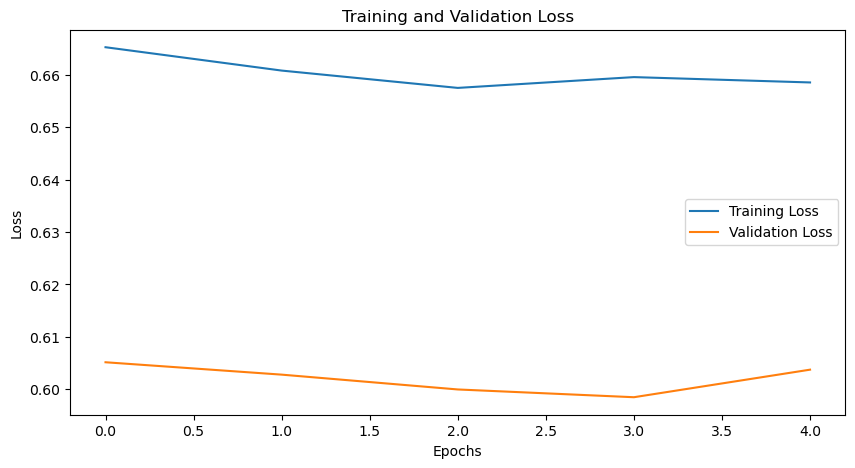

CPU times: user 4h 36min 53s, sys: 23min 16s, total: 5h 9s
Wall time: 12min 30s


In [129]:
%%time
# Initialize Model
# Update input_dim to include one-hot encoded permno_id length
# input_dim = 128*5+1
input_dim = stock_number + 2 + stock_number*7
model = TransformerModel(
    input_dim=input_dim,
    embed_dim=256,
    n_heads=16,
    ff_dim=1024,
    n_layers=1,
    output_dim=len(train_dataset.target_columns),
    # output_dim=1,
    dropout=0.25,
    attn_dropout=0.1,
    residual_dropout=0.1,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training Loop
optimizer = torch.optim.RAdam(model.parameters(), lr=0.00005)
criterion = nn.L1Loss()
# criterion = nn.MSELoss()

train_losses = []
val_losses = []

num_epochs = 200
patience = 5
best_val_loss = float("inf")
patience_counter = 0

print("Starting Training...")
total_batches = num_epochs * len(train_dataloader)
total_start_time = time.time()

for epoch in range(num_epochs):
    start_time = time.time()  # Record the start time
    model.train()
    running_loss = 0.0
    batch_start_time = time.time()

    for i, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        output, _ = model(batch["features"].to(device))
        loss = criterion(output, batch["target"].to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 1000 == 0:
            # print(f"Batch {i}, Loss: {loss}, train_loss: {running_loss}")
            elapsed_time = time.time() - batch_start_time
            remaining_batches = len(train_dataloader) - (i + 1)
            estimated_remaining_time_epoch = remaining_batches * (elapsed_time / (i + 1))

            total_elapsed_time = time.time() - total_start_time
            total_remaining_batches = total_batches - ((epoch * len(train_dataloader)) + (i + 1))
            estimated_remaining_time_total = total_remaining_batches * (
                total_elapsed_time / ((epoch * len(train_dataloader)) + (i + 1))
            )

            print(time.strftime("%H:%M:%S", time.localtime()))

            print(
                f"Batch {i}/{len(train_dataloader)}, Loss: {loss:.4f}, "
                f"Estimated time left for epoch: {time.strftime('%H:%M:%S', time.gmtime(estimated_remaining_time_epoch))}, "
                f"Estimated time left for training: {time.strftime('%H:%M:%S', time.gmtime(estimated_remaining_time_total))}"
            )

    train_losses.append(running_loss / len(train_dataloader))

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_dataloader:
            output, _ = model(batch["features"].to(device))
            loss = criterion(output, batch["target"].to(device))
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_dataloader))

    epoch_time = time.time() - start_time  # Calculate the elapsed time
    print(f"Epoch {epoch+1}/{num_epochs} took {epoch_time:.2f} seconds")
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

print("Training Complete")

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

#### Plot Prediction vs True Values (scaler.inverse_transform)


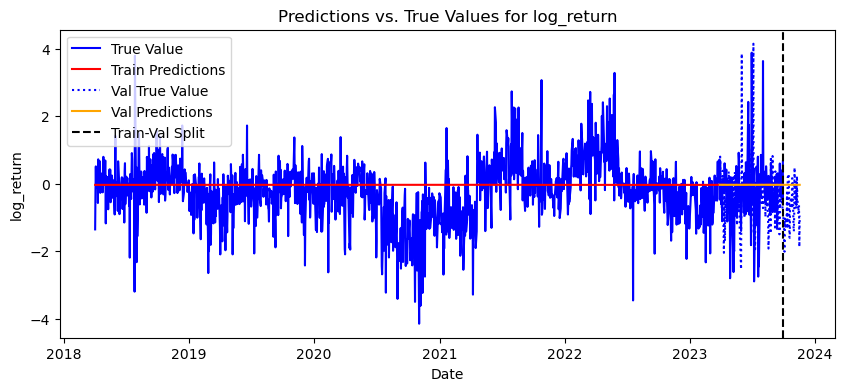

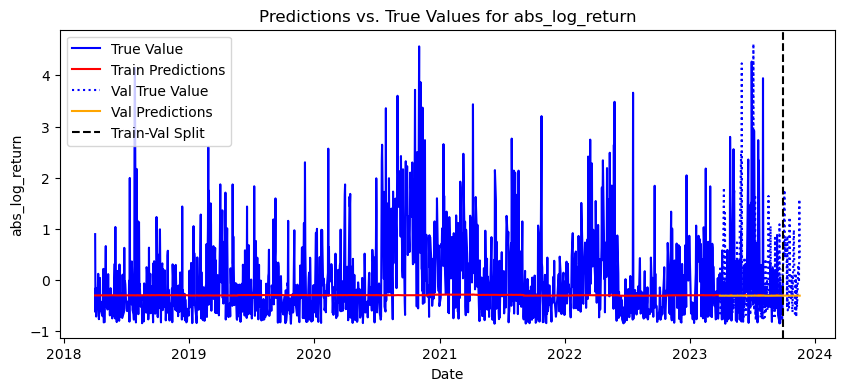

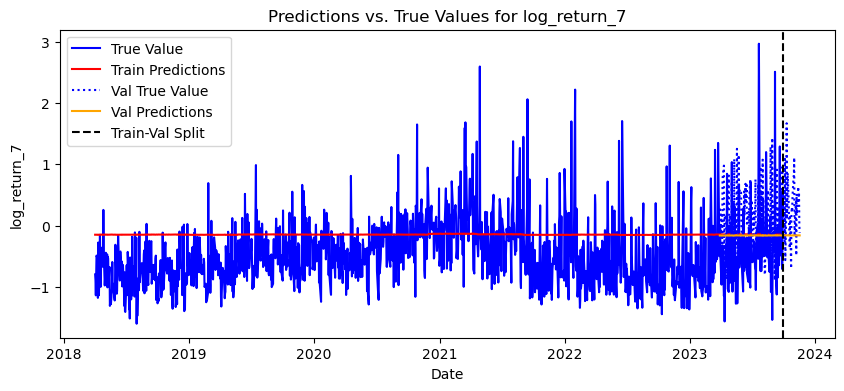

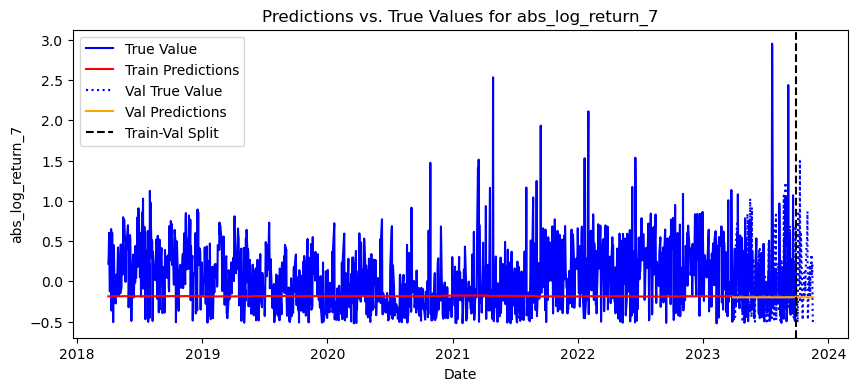

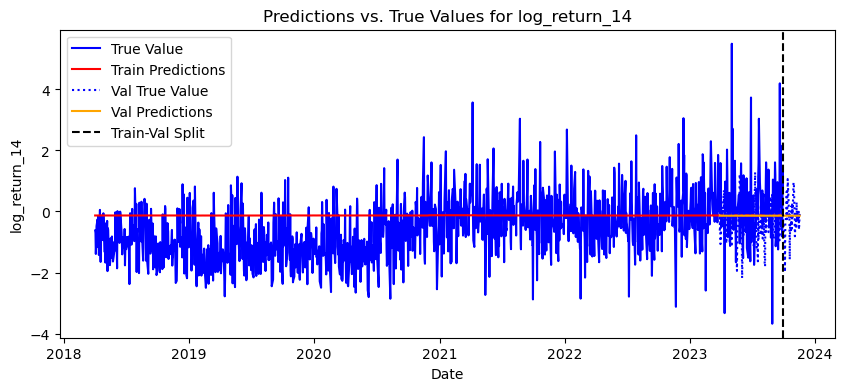

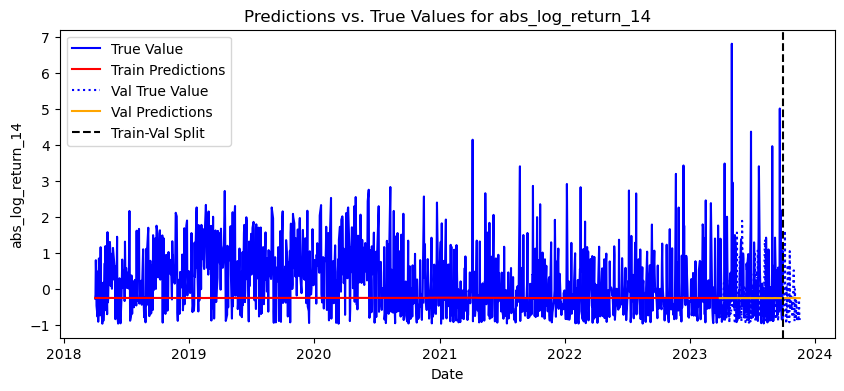

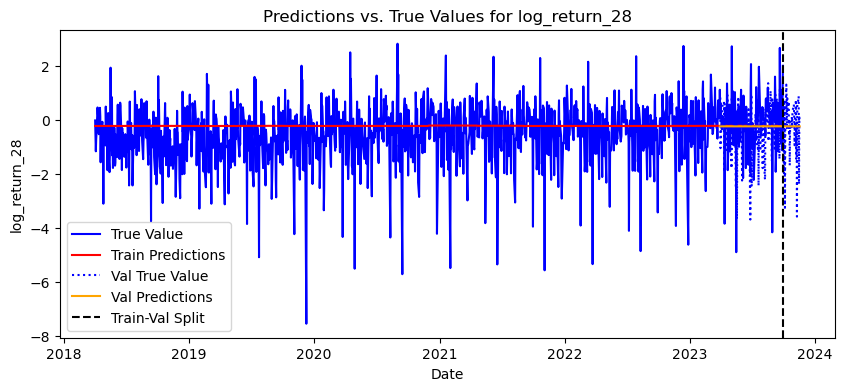

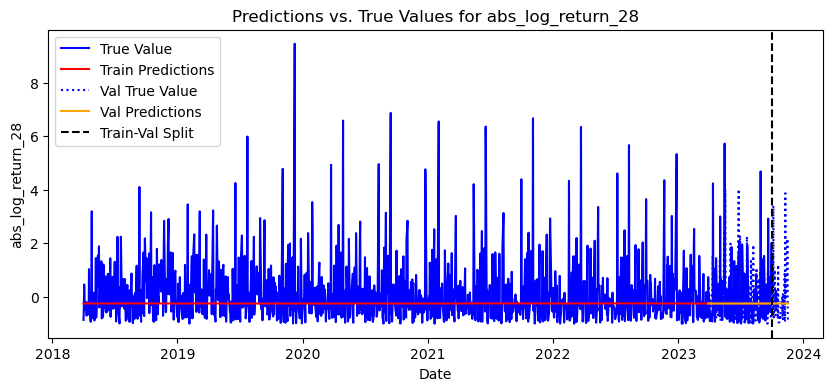

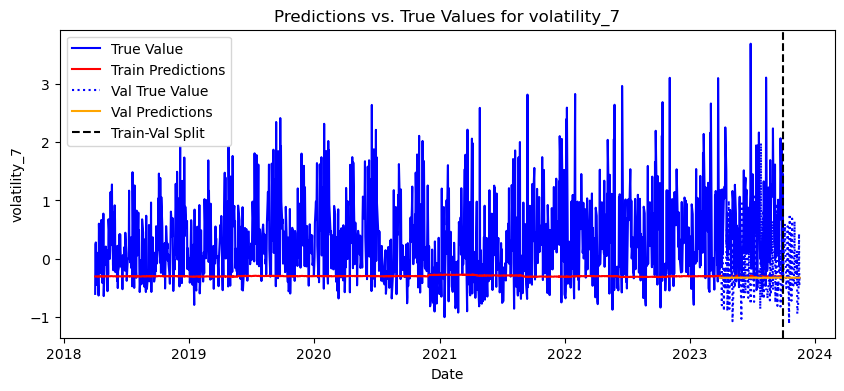

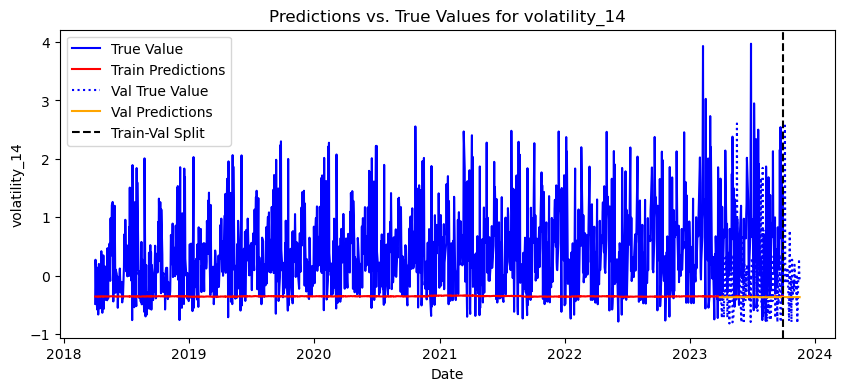

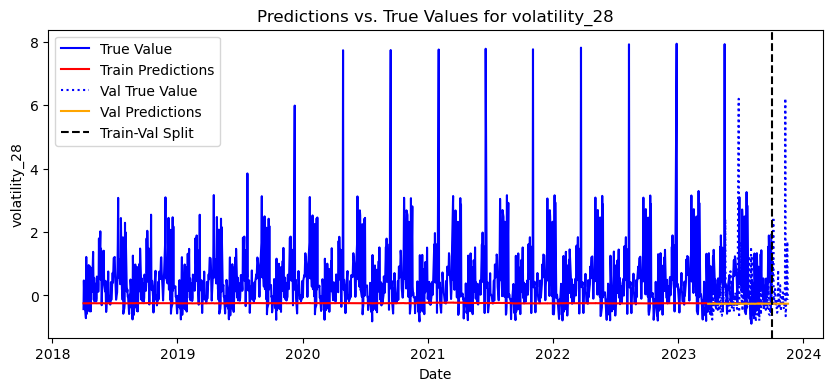

In [133]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler

# Assuming the model and dataloaders are already defined and trained
# Also assuming the cleaned_data is available

target_scaler = StandardScaler()
cleaned_data[train_dataset.target_columns] = target_scaler.fit_transform(cleaned_data[train_dataset.target_columns])

# Function to get predictions
def get_predictions(dataloader, model, device):
    model.eval()
    predictions = []
    true_values = []
    with torch.no_grad():
        for batch in dataloader:
            features = batch["features"].to(device)
            target = batch["target"].to(device)
            output, _ = model(features)
            predictions.append(output.cpu().numpy())
            true_values.append(target.cpu().numpy())
    return np.concatenate(predictions), np.concatenate(true_values)

# Get predictions for training and validation datasets
train_predictions, train_true_values = get_predictions(train_dataloader, model, device)
val_predictions, val_true_values = get_predictions(val_dataloader, model, device)

# Reshape predictions and true values to 2D arrays
train_predictions = train_predictions.reshape(-1, len(train_dataset.target_columns))
train_true_values = train_true_values.reshape(-1, len(train_dataset.target_columns))
val_predictions = val_predictions.reshape(-1, len(val_dataset.target_columns))
val_true_values = val_true_values.reshape(-1, len(val_dataset.target_columns))

# Inverse transform the predictions and true values using target_scaler
train_predictions = target_scaler.inverse_transform(train_predictions)
train_true_values = target_scaler.inverse_transform(train_true_values)
val_predictions = target_scaler.inverse_transform(val_predictions)
val_true_values = target_scaler.inverse_transform(val_true_values)

# Convert predictions and true values to DataFrame
train_predictions_df = pd.DataFrame(train_predictions, columns=train_dataset.target_columns)
train_true_values_df = pd.DataFrame(train_true_values, columns=train_dataset.target_columns)
val_predictions_df = pd.DataFrame(val_predictions, columns=val_dataset.target_columns)
val_true_values_df = pd.DataFrame(val_true_values, columns=val_dataset.target_columns)

# Ensure the date columns have matching lengths
train_dates = train_input_data.index[-len(train_predictions_df):]
val_dates = val_input_data.index[:len(val_predictions_df)]

# Match the lengths by slicing or padding appropriately
train_predictions_df = train_predictions_df.iloc[:len(train_dates)]
train_true_values_df = train_true_values_df.iloc[:len(train_dates)]
train_predictions_df["date"] = train_dates
train_true_values_df["date"] = train_dates

val_predictions_df = val_predictions_df.iloc[:len(val_dates)]
val_true_values_df = val_true_values_df.iloc[:len(val_dates)]
val_predictions_df["date"] = val_dates
val_true_values_df["date"] = val_dates

# Plotting function for each label
def plot_predictions_vs_true(label):
    plt.figure(figsize=(10, 4))

    # Plot the train data
    plt.plot(train_true_values_df["date"], train_true_values_df[label], label="True Value", color="blue")
    plt.plot(train_predictions_df["date"], train_predictions_df[label], label="Train Predictions", color="red")
    plt.plot(val_true_values_df["date"], val_true_values_df[label], label="Val True Value", color="blue", linestyle='dotted')
    plt.plot(val_predictions_df["date"], val_predictions_df[label], label="Val Predictions", color="orange")

    plt.axvline(x=pd.to_datetime("2023-09-30"), color="black", linestyle="--", label="Train-Val Split")

    plt.xlabel("Date")
    plt.ylabel(label)
    plt.title(f"Predictions vs. True Values for {label}")
    plt.legend()
    plt.show()

# Plot for all labels
for label in train_dataset.target_columns:
    plot_predictions_vs_true(label)


In [134]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import torch
# from torch.utils.data import DataLoader
# from sklearn.preprocessing import StandardScaler

# # Assuming the model and dataloaders are already defined and trained
# # Also assuming the cleaned_data is available

# target_scaler = StandardScaler()
# cleaned_data[train_dataset.target_columns] = target_scaler.fit_transform(
#     cleaned_data[train_dataset.target_columns]
# )


# # Function to get predictions
# def get_predictions(dataloader, model, device):
#     model.eval()
#     predictions = []
#     true_values = []
#     with torch.no_grad():
#         for batch in dataloader:
#             features = batch["features"].to(device)
#             target = batch["target"].to(device)
#             output, _ = model(features)
#             # print(output.shape)
#             predictions.append(output.cpu().numpy())
#             true_values.append(target.cpu().numpy())
#     return np.concatenate(predictions), np.concatenate(true_values)


# # Get predictions for training and validation datasets
# train_predictions, train_true_values = get_predictions(train_dataloader, model, device)
# val_predictions, val_true_values = get_predictions(val_dataloader, model, device)

# # Reshape predictions and true values to 2D arrays
# train_predictions = train_predictions.reshape(-1, len(train_dataset.target_columns))
# train_true_values = train_true_values.reshape(-1, len(train_dataset.target_columns))
# val_predictions = val_predictions.reshape(-1, len(val_dataset.target_columns))
# val_true_values = val_true_values.reshape(-1, len(val_dataset.target_columns))

# # Inverse transform the predictions and true values using target_scaler
# train_predictions = target_scaler.inverse_transform(train_predictions)
# train_true_values = target_scaler.inverse_transform(train_true_values)
# val_predictions = target_scaler.inverse_transform(val_predictions)
# val_true_values = target_scaler.inverse_transform(val_true_values)

# # Convert predictions and true values to DataFrame
# train_predictions_df = pd.DataFrame(train_predictions, columns=train_dataset.target_columns)
# train_true_values_df = pd.DataFrame(train_true_values, columns=train_dataset.target_columns)
# val_predictions_df = pd.DataFrame(val_predictions, columns=val_dataset.target_columns)
# val_true_values_df = pd.DataFrame(val_true_values, columns=val_dataset.target_columns)

# # Ensure the date columns have matching lengths
# # train_dates = train_data.iloc[window_size : len(train_predictions) + window_size]["date"].values
# # if len(train_dates) < len(train_predictions_df):
# #     train_dates = np.append(train_dates, [train_dates[-1]] * (len(train_predictions_df) - len(train_dates)))
# # train_predictions_df["date"] = train_dates
# # train_true_values_df["date"] = train_dates

# # val_dates = validation_data.iloc[window_size : len(val_predictions) + window_size]["date"].values
# # if len(val_dates) < len(val_predictions_df):
# #     val_dates = np.append(val_dates, [val_dates[-1]] * (len(val_predictions_df) - len(val_dates)))
# # val_predictions_df["date"] = val_dates
# # val_true_values_df["date"] = val_dates


# # Plotting function for each label
# def plot_predictions_vs_true(label):
#     plt.figure(figsize=(10, 4))

#     # Plot the train data
#     plt.plot(train_true_values_df.index, train_true_values_df[label], label="True Value", color="blue")

#     plt.plot(train_predictions_df.index, train_predictions_df[label], label="Train Predictions", color="red")
#     plt.plot(val_predictions_df.index, val_predictions_df[label], label="Val Predictions", color="orange")

#     plt.axvline(x=pd.to_datetime("2023-09-30"), color="black", linestyle="--", label="Train-Val Split")

#     plt.xlabel("Date")
#     plt.ylabel(label)
#     plt.title(f"Predictions vs. True Values for {label}")
#     plt.legend()
#     plt.show()


# # Plot for all labels
# for label in train_dataset.target_columns:
#     plot_predictions_vs_true(label)

#### Input Embedding Weights


In [ ]:
input_embedding_weights = model.input_embedding.weight.detach().cpu().numpy().T
print(input_embedding_weights)

In [ ]:
input_embedding_weights[-stock_number:].shape

In [ ]:
cosine_sim_matrix_input_embedding_weights = cosine_similarity(input_embedding_weights)
cosine_sim_matrix_input_embedding_weights

In [ ]:
pd.DataFrame(cosine_sim_matrix_input_embedding_weights).to_csv("cosine_sim_matrix_input_embedding_weights_100_2.csv")

In [ ]:
# Plot the cosine similarity matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cosine_sim_matrix_input_embedding_weights, annot=False, cmap="viridis")
plt.title("Cosine Similarity Matrix of Input Embedding Weights")
plt.xlabel("Embedding Index")
plt.ylabel("Embedding Index")
plt.show()

In [ ]:
# fc_weights = model.fc.weight.detach().cpu().numpy()
# print(fc_weights)

In [ ]:
# fc_weights.shape

In [ ]:
# cosine_sim_matrix_fc_weights = cosine_similarity(fc_weights)
# cosine_sim_matrix_fc_weights

In [ ]:
# plt.figure(figsize=(10, 8))
# sns.heatmap(cosine_sim_matrix_fc_weights, annot=False, cmap='viridis')
# plt.title('Cosine Similarity Matrix of Input Embedding Weights')
# plt.xlabel('Embedding Index')
# plt.ylabel('Embedding Index')
# plt.show()

#### Feed_Forward Weights


In [ ]:
# # To get the weights of the first encoder layer
# encoder_layer_weights = model.transformer.layers[0].state_dict()
# encoder_layer_weights

In [ ]:
# # If you want to get the weights of all encoder layers
# all_encoder_layers_weights = [layer.state_dict() for layer in model.transformer.layers]
# all_encoder_layers_weights

In [ ]:
# # Attention weights
# attention_weights = encoder_layer_weights['self_attn.in_proj_weight']

# # Feedforward weights
# feedforward_weights = encoder_layer_weights['linear1.weight']

# print("Attention Weights:", attention_weights.shape)
# print("Feedforward Weights:", feedforward_weights.shape)

In [ ]:
# feedforward_weights_matrix = feedforward_weights.cpu().numpy()
# feedforward_weights_matrix

In [ ]:
# cosine_sim_matrix_feedforward_weights = cosine_similarity(feedforward_weights_matrix)
# cosine_sim_matrix_feedforward_weights

In [ ]:
# # Plot the cosine similarity matrix as a heatmap
# plt.figure(figsize=(10, 8))
# sns.heatmap(cosine_sim_matrix_feedforward_weights, annot=False, cmap='viridis')
# plt.title('Cosine Similarity Matrix of Input Embedding Weights')
# plt.xlabel('Embedding Index')
# plt.ylabel('Embedding Index')
# plt.show()

#### Extract Last Output Embedding


In [ ]:
# Extract embeddings for each stock
stock_embeddings = {}
model.eval()
with torch.no_grad():
    for batch in train_dataloader:
        _, embeddings = model(batch["features"].to(device))
        for i, permno_id in enumerate(batch["permno_id"]):
            stock_embeddings[permno_id] = embeddings[i].cpu().numpy()  # Keep only the last embedding

In [ ]:
%%time
# Assuming stock_embeddings is a dictionary with permno_id as keys and embeddings as values
embeddings_list = []
permno_ids = []

for permno_id, embedding in stock_embeddings.items():
    permno_ids.append(permno_id)
    embeddings_list.append(embedding)

# Convert the list of embeddings to a numpy array
embeddings_array = np.array(embeddings_list)

# Transform embeddings using cosine similarity
cosine_sim_matrix = cosine_similarity(embeddings_array)
cosine_sim_matrix

In [ ]:
# Plot the cosine similarity matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cosine_sim_matrix, annot=False, cmap="viridis")
plt.title("Cosine Similarity Matrix")
plt.xlabel("Embedding Index")
plt.ylabel("Embedding Index")
plt.show()

In [ ]:
pd.DataFrame(cosine_sim_matrix).to_csv("cosine_sim_matrix_100_2.csv")

In [ ]:
# with torch.no_grad():
#     for batch in train_dataloader:
#         _, embeddings = model(batch["features"].to(device))

In [ ]:
# # output_embedding_matrix = embeddings[:,-1,:].cpu().numpy()
# output_embedding_matrix = embeddings.cpu().numpy()
# output_embedding_matrix

In [ ]:
# output_embedding_matrix.shape

In [ ]:
# cosine_sim_matrix_out_embedding = cosine_similarity(output_embedding_matrix)
# cosine_sim_matrix_out_embedding

In [ ]:
# # Plot the cosine similarity matrix as a heatmap
# plt.figure(figsize=(10, 8))
# sns.heatmap(cosine_sim_matrix_out_embedding, annot=False, cmap='viridis')
# plt.title('Cosine Similarity Matrix of Output Embedding Weights')
# plt.xlabel('Embedding Index')
# plt.ylabel('Embedding Index')
# plt.show()

#### Average Output Embedding


In [ ]:
%%time
# Extract embeddings for each stock
stock_embeddings = {}
model.eval()
with torch.no_grad():
    for batch in train_dataloader:
        _, embeddings = model(batch["features"].to(device))
        for i, permno_id in enumerate(batch["permno_id"]):
            if permno_id not in stock_embeddings:
                stock_embeddings[permno_id] = []
            stock_embeddings[permno_id].append(embeddings[i].cpu().numpy())

In [ ]:
%%time
# Average the embeddings for each stock
for permno_id in stock_embeddings:
    stock_embeddings[permno_id] = np.mean(stock_embeddings[permno_id], axis=0)

In [ ]:
%%time
# Assuming stock_embeddings is a dictionary with permno_id as keys and embeddings as values
embeddings_list = []
permno_ids = []

for permno_id, embedding in stock_embeddings.items():
    permno_ids.append(permno_id)
    embeddings_list.append(embedding)

# Convert the list of embeddings to a numpy array
embeddings_array = np.array(embeddings_list)

# Transform embeddings using cosine similarity
cosine_sim_matrix = cosine_similarity(embeddings_array)
cosine_sim_matrix

In [ ]:
# Plot the cosine similarity matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cosine_sim_matrix, annot=False, cmap="viridis")
plt.title("Cosine Similarity Matrix")
plt.xlabel("Embedding Index")
plt.ylabel("Embedding Index")
plt.show()

In [ ]:
# # Initialize an empty tensor to accumulate the embeddings
# accumulated_embeddings = torch.zeros(128, 256).to(device)
# total_batches = 0

# with torch.no_grad():
#     for batch in train_dataloader:
#         _, embeddings = model(batch["features"].to(device))
#         #print(embeddings)
#         accumulated_embeddings += embeddings.sum(dim=1)
#         # total_batches += batch["features"].size(0)
#         total_batches += embeddings.size(1)

# # Divide the accumulated embeddings by the total number of batches to get the average
# average_embeddings = accumulated_embeddings / total_batches
# print(total_batches)
# average_embeddings

In [ ]:
# average_embeddings.shape

In [ ]:
# batch["features"].shape

In [ ]:
# batch["features"].size(0)

In [ ]:
# # Plot the cosine similarity matrix as a heatmap
# plt.figure(figsize=(10, 8))
# sns.heatmap(cosine_similarity(average_embeddings.cpu().numpy()), annot=False, cmap='viridis')
# plt.title('Cosine Similarity Matrix of Input Embedding Weights')
# plt.xlabel('Embedding Index')
# plt.ylabel('Embedding Index')
# plt.show()